In [1]:
## Standard Library
import os
import json

## External Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torchsummary import summary
import torchio as tio
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from skimage import io
import SimpleITK as sitk
import matplotlib.pyplot as plt
import torch.nn.functional as F
import nibabel as nib
from HD_BET.utils import subdirs, subfiles


CREATE DIRECTORIES

In [2]:
# General Data Directory ##TODO: Please fill in the appropriate directory
data_dir = os.path.join("Registered")
# data_dir = os.path.join(dir, "DATA")
# mask_dir = os.path.join(dir, "MASK")
# label_dir = dir

CONVOLUTIONAL LAYER CALCULATIONS

In [16]:
# temp = sitk.Image()

# for f in os.listdir(data_dir):
#     img = sitk.ReadImage(os.path.join(data_dir, f))
#     sz = img.GetSize()
#     pad = [865-sz[0], 682-sz[1], 354-sz[2]]
#     img = 
#     print(img.GetSize())
    # img = torch.tensor(sitk.GetArrayFromImage(img))
    # pad = (0, 864-img.size()[2], 0, 682-img.size()[1], 0, 354-img.size()[0])
    # img = nn.functional.pad(img[None, :], pad, value=0)
    
# for g in os.listdir(mask_dir):
#     mask = sitk.ReadImage(f)
#     mask = torch.tensor(sitk.GetArrayFromImage(mask))
#     pad = (0, 864-mask.size()[2], 0, 682-mask.size()[1], 0, 354-mask.size()[0])
#     mask = nn.functional.pad(mask[None, :], pad, value=0)
# layer 1, torch.Size([1, 8, 177, 341, 432])
# layer 2, torch.Size([1, 16, 89, 171, 216])
# layer 3, torch.Size([1, 32, 45, 86, 108])
# layer 4, torch.Size([1, 64, 23, 43, 54])
# us43 size torch.Size([1, 32, 46, 86, 108])
stride = 1
padding = 1
dilation = 1
kernel = 3
poolsize = 2
input_dim = np.array([182, 218, 182])
input_dim = input_dim / 1.25
# print(f"Output spatial dimensions: {input_dim}, Total elements: {numelements/(1e3):.3f}, Size: {numelements*bytes_per_element/(1E9):.3f} GB")
# input_dim = np.array([288, 227, 118])
# input_dim = np.array([96, 75, 39])
# Conv3dTranpose:
# output_dim = (input_dim - 1) * stride - 2 * padding + dilation * (kernel - 1) + output_padding + 1
# Conv3d:
numkernels = [8, 16, 32, 64]
for k in range(len(numkernels)):
    print(f'Layer {k+1}')
    output_dim = np.floor((input_dim + 2*padding - dilation*(kernel - 1) - 1) / stride + 1)
    numelements = np.prod(output_dim)*numkernels[k]
    bytes_per_element = 4.0
    print(f"Output spatial dimensions: {output_dim}, Total elements: {numelements/(1e3):.3f}, Size: {numelements*bytes_per_element/(1E9):.3f} GB")
    if k < 3:
        output_dim = np.floor(output_dim/poolsize) # max pooling
    input_dim = output_dim

kernel = 4
stride = 2
padding = 1
output_padding = np.array([[0, 1, 0], [0, 1, 0], [1, 0, 1]])
numkernels.reverse()
numkernels = numkernels[1:]
for k in range(len(numkernels)):
    print(f'Layer {k+1}m')
    output_dim = np.floor((input_dim - 1)*stride - 2*padding + dilation*(kernel - 1) + output_padding[k] + 1)
    numelements = np.prod(output_dim)*numkernels[k]
    bytes_per_element = 4.0
    print(f"Output spatial dimensions: {output_dim}, Total elements: {numelements}, Size: {numelements*bytes_per_element/(1E9)} GB")
    input_dim = output_dim

Layer 1
Output spatial dimensions: [145. 174. 145.], Total elements: 29266.800, Size: 0.117 GB
Layer 2
Output spatial dimensions: [72. 87. 72.], Total elements: 7216.128, Size: 0.029 GB
Layer 3
Output spatial dimensions: [36. 43. 36.], Total elements: 1783.296, Size: 0.007 GB
Layer 4
Output spatial dimensions: [18. 21. 18.], Total elements: 435.456, Size: 0.002 GB
Layer 1m
Output spatial dimensions: [36. 43. 36.], Total elements: 1783296.0, Size: 0.007133184 GB
Layer 2m
Output spatial dimensions: [72. 87. 72.], Total elements: 7216128.0, Size: 0.028864512 GB
Layer 3m
Output spatial dimensions: [145. 174. 145.], Total elements: 29266800.0, Size: 0.1170672 GB


IMAGE DATASET CLASS

In [21]:
## Image Transforms
img_transform = transforms.Compose([
        transforms.ToTensor(),
])

## Image Dataloader
class ImageDataset(Dataset):
    
    """
    ImageDataset
    """
    
    def __init__(self,
                 data_dir
                 transforms=None):
        """
        ##TODO: Add support for colorization dataset
        
        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.input_dir = data_dir
        self.subjects = subdirs(self.input_dir)
        # for dirname in subdirs(self.input_dir):
        #     self.input_files.extend(subfiles(dirname))
        # self.output_files = [ifile[:-7]+"_bet.nii.gz" for ifile in self.input_files]
        self.transform = transforms

    def __len__(self):
        """
        
        """
        return len(next(os.walk(self.input_dir))[2])

    def __getitem__(self,
                    idx):
        """
        
        """

        T1w = nib.load(os.path.join(f"{self.subjects[idx]:03d}", "T1w_1mm.nii.gz"))
        T2w = nib.load(os.path.join(f"{self.subjects[idx]:03d}", "T2w_align.nii.gz"))
        ADC = nib.load(os.path.join(f"{self.subjects[idx]:03d}", "ADC_align.nii.gz"))
        FA = nib.load(os.path.join(f"{self.subjects[idx]:03d}", "FA_align.nii.gz"))
        # Create tensors
        T1wdata = torch.tensor(T1w.get_fdata)
        T2wdata = torch.tensor(T2w.get_fdata)
        FAdata = torch.tensor(FA.get_fdata)
        ADCdata = torch.tensor(ADC.get_fdata)
        
#         # NORMALIZE
#         mean = 54.4651
#         std = 44.4922
#         img = (img - mean) / std
        
#             # read the processed image
#         ## Transform image and mask
# #         if self.transform:
#         if idx < 70:
#             img, mask = self.img_transform(img, mask, augtype)
# # #         print(img.size())
#             widths = np.array([44, 85, 108])*2
#             dims = 2*widths
#         else:
#             dims = [354, 682, 864]
# #         print(dims)
#         pad = (0, dims[2]-img.size()[2], 0, dims[1]-img.size()[1], 0, dims[0]-img.size()[0])
#         img = nn.functional.pad(img[None, :], pad, value=0)
#         mask = nn.functional.pad(mask[None, :], pad, value=0)
#         print(img.size())
        input = torch.cat([T1wdata[None], T2wdata[None]])
        target = torch.cat([FAdata[None], ADCdata[None]])
        input = nn.functional.interpolate(input[None], target[0].size())
        # ## Use dictionary to output
        return input[0], target

    def img_transform(self,
                      img,
                      mask,
                      aug):
        """
        
        """
#         buffer = 100
#         print(img.shape)
        tumoridx = torch.nonzero(mask).float() # result will be N(nonz px)x3(l,w,h)
#         # print(tumoridx.size())

#         # Get the centroid of the tumor and upper and lower bounds in each dimension
        tcenter = torch.mean(tumoridx, dim=0) # result is 1x3(l,w,h)
        widths = np.array([44, 85, 108])*2
        xlow = int(max(0, tcenter[0] - widths[0]))
        ylow = int(max(0, tcenter[1] - widths[1]))
        zlow = int(max(0, tcenter[2] - widths[2]))
        xhigh = int(min(img.shape[0], xlow + 2*widths[0]))
        if xhigh - xlow < widths[0]*2:
            xlow = xhigh - widths[0]*2
        yhigh = int(min(img.shape[1], ylow + 2*widths[1]))
        if yhigh - ylow < widths[1]*2:
            ylow = yhigh - widths[1]*2
        zhigh = int(min(img.shape[2], zlow + 2*widths[2]))
        if zhigh - zlow < widths[2]*2:
            zlow = zhigh - widths[2]*2
        img = img[xlow:xhigh, ylow:yhigh, zlow:zhigh]
        mask = mask[xlow:xhigh, ylow:yhigh, zlow:zhigh]
#         print(img.shape, xlow, ylow, zlow)
#         tmins = torch.min(tumoridx, dim=0)[0]
#         tmaxes = torch.max(tumoridx, dim=0)[0]
        
#         torch.Size([349, 682, 865])
#         torch.Size([121, 340, 432]) 228 108 255
#         torch.Size([0, 70, 100]) [tensor([134]), tensor([13]), tensor([5])]
        # Apply Random Transformations to Image and Mask
        if aug == 0:
            flipdim = torch.randint(low=0, high=3, size=(1,))
            img = torch.flip(img, dims=[flipdim])
            mask = torch.flip(mask, dims=[flipdim])
#             print(f'flipping dim {flipdim}')
        elif aug == 1:
            cropsize = (40, 70, 100)
            minbounds = [torch.randint(low=0, high=2*widths[0]-cropsize[0], size=(1,)),
                         torch.randint(low=0, high=2*widths[1]-cropsize[1], size=(1,)),
                         torch.randint(low=0, high=2*widths[2]-cropsize[2], size=(1,))]
            img = img[minbounds[0]:(minbounds[0]+cropsize[0]), 
                      minbounds[1]:(minbounds[1]+cropsize[1]), 
                      minbounds[2]:(minbounds[2]+cropsize[2])]
            mask = mask[minbounds[0]:(minbounds[0]+cropsize[0]), 
                        minbounds[1]:(minbounds[1]+cropsize[1]), 
                        minbounds[2]:(minbounds[2]+cropsize[2])]
#             print(img.shape, minbounds)
            resize = (int(cropsize[0]/cropsize[2]*max(2*widths)), int(cropsize[1]/cropsize[2]*max(2*widths)), max(2*widths))
            img = nn.functional.interpolate(img[None, None, :, :, :].float(), size=resize, mode='trilinear')
            mask = nn.functional.interpolate(mask[None, None, :, :, :].float(), size=resize, mode='trilinear')
            img = img[0, 0]
            mask = torch.round(mask[0, 0])
#         else:
#             rotatedim = torch.randint(low=0, high=3, size=(1,))
#             for i in range(img.shape[rotatedim]):
#                 img[:, :, i] = 
#             print(f'cropping {img.shape}')

        return img, mask

UNET ARCHITECTURE

In [5]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   dilation=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
          nn.ReLU(),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=1, padding=padding, dilation=dilation, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine,
             stride=2,
             padding=1,
             output_padding=(0, 0, 0)):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose3d(ch_coarse, ch_fine, kernel_size=4, stride=stride, padding=padding, output_padding=output_padding, bias=False),
                    nn.ReLU())


# U-Net
class UNET(nn.Module):
    
    """
    
    """
    def __init__(self, n_classes, useBN=True):
        """
        Args:
            n_classes (int): Number of classes
            useBN (bool): Turn Batch Norm on or off. (Hint: Using BatchNorm might help you achieve better performance.)
        """
        super(UNET, self).__init__()
        torch.manual_seed(42)
        # Downgrade stages
        dilation = 1
        stride = 1
        
        # self.conv1 = add_conv_stage(3, 32, useBN=useBN) # for segmentation training
        self.conv1 = add_conv_stage(2, 8, stride=stride, dilation=dilation, useBN=useBN) # for colorization training
        self.conv2 = add_conv_stage(8, 16, stride=stride, dilation=dilation, useBN=useBN)
        self.conv3 = add_conv_stage(16, 32, stride=stride, dilation=dilation, useBN=useBN)
        self.conv4 = add_conv_stage(32, 64, stride=stride, dilation=dilation, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(64, 32, dilation=dilation, useBN=useBN)
        self.conv2m = add_conv_stage(32,  16, dilation=dilation, useBN=useBN)
        self.conv1m = add_conv_stage( 16,  8, dilation=dilation, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool3d(2)
        # self.max_pool = nn.Identity()
        # Upsample layers
        # [0, 1, 0], [0, 1, 0], [1, 0, 1]
        self.upsample43 = upsample(64, 32, output_padding=(0, 1, 0))
        self.upsample32 = upsample(32,  16, output_padding=(0, 1, 0))
        self.upsample21 = upsample(16 ,  8, output_padding=(1, 0, 1))
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
                if m.bias is not None:
                    m.bias.data.zero_()
        #TODO: Design your last layer & activations
        # Segmentation w/o coloring:
        # self.convFinal = nn.Sequential(nn.Conv2d(32, n_classes, kernel_size=1, stride=1, padding=0, bias=True),
                                    #    nn.ReLU())
        # Colorization and colorization+segmentation:
        self.un_pool = nn.MaxUnpool3d(4)
        self.convFinal = nn.Sequential(nn.Conv3d(2, n_classes, kernel_size=1, stride=1, padding=0, bias=True),
                                       nn.ReLU())
        # self.lastLin = nn.Linear(3, 6)
        


    def forward(self, x):
        """
        Forward pass
        """
#         print(x.size())
        xsize = x.size()
        if self.training:
            scaled = self.avg_pooltrain(x)
        else:
            scaled = self.avg_pooleval(x)
#         print(f'scaling down', {scaled.size()})
        conv1_out = self.conv1(scaled)
#         print(f'layer 1, {conv1_out.size()}')
        conv2_out = self.conv2(self.max_pool(conv1_out))
#         print(f'layer 2, {conv2_out.size()}')
        conv3_out = self.conv3(self.max_pool(conv2_out))
#         print(f'layer 3, {conv3_out.size()}')
        conv4_out = self.conv4(self.max_pool(conv3_out))
#         print(f'layer 4, {conv4_out.size()}')

        us43 = self.upsample43(conv4_out)
#         print(f'us43 size {us43.size()}')
        conv4m_out_ = torch.cat((us43, conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)
#         print(f'layer 3m, {conv3m_out.size()}')

        us32 = self.upsample32(conv3m_out)
#         print(f'us32 size {us32.size()}')
        conv3m_out_ = torch.cat((us32, conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)
#         print(f'layer 2m, {conv2m_out.size()}')

        us21 = self.upsample21(conv2m_out)
#         print(f'us21 size {us21.size()}')
        conv2m_out_ = torch.cat((us21, conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)
#         print(f'layer 1m, {conv1m_out.size()}')
#         c1msize = conv1m_out.size()
        #TODO: Design your last layer & activations
        out = self.convFinal(conv1m_out)
#         print(f'layer out, {out.size()}')

        # outscaled = nn.functional.interpolate(out, size=xsize[-3:])
        # print(f'layer out scaled, {outscaled.size()}')
        
        return out


DICE LOSS/SCORES

In [6]:
##TODO: Finish implementing the multi-class DICE score function
def dice_score_image(prediction, target, n_classes):
    '''
      computer the mean dice score for a single image

      Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
      Args:
          prediction (tensor): predictied labels of the image
          target (tensor): ground truth of the image
          n_classes (int): number of classes
    
      Returns:
          m_dice (float): Mean dice score over classes
    '''
    ## Should test image one by one
    assert prediction.shape[0] == 1 #This line can not be deleted
    ## TODO: Compute Dice Score for Each Class. Compute Mean Dice Score over Classes.
#     dice_classes = torch.zeros(n_classes)
    # print(prediction.shape, target.shape)
#     print(prediction.shape)
#     pd = pd[0].long()
#     prediction = nn.functional.one_hot(prediction, num_classes=n_classes).permute(0, 4, 1, 2, 3)
    
    # If we want to scale down target
#     pool = nn.AvgPool3d(4)
#     target = pool(target)
    # If we want to scale up prediction
    
#     target = torch.cat([target, 1-target], dim=1)
#     print(prediction.shape, target.shape)
#     prediction = prediction.float()
#     target = target.float()
#     TP_0 = 0
#     TP_1 = 0
#     FP_0 = 0
#     FP_1 = 0
#     FN_0 = 0
#     FN_1 = 0
    prediction = prediction.int()
    TP_0 = (prediction[0]*target[0]).sum()
    TP_1 = ((1-prediction[0])*(1-target[0])).sum()
    FP_0 = (prediction[0]*(1-target[0])).sum()
    FP_1 = ((1-prediction[0])*target[0]).sum()
    FN_0 = FP_1 #((1-prediction[0])*target[0]).sum()
    FN_1 = FP_0 #((prediction[0])*(1-target[0])).sum()
#     for a in range(prediction.shape[1]):
#         for b in range(prediction.shape[2]):
#             for c in range(prediction.shape[3]):
#                 TP_0 += (prediction[0, a, b, c]*target[0, 0, a, b, c])
#                 TP_1 += ((1-prediction[0, a, b, c])*(1-target[0, 0, a, b, c]))
#                 FP_1 += ((1-prediction[0, a, b, c])*target[0, 0, a, b, c])
#                 FP_0 += (prediction[0, a, b, c]*(1-target[0, 0, a, b, c]))
#                 FN_0 += ((1-prediction[0, a, b, c])*target[0, 0, a, b, c])
#                 FN_1 += ((1-(1-prediction[0, a, b, c]))*(1-target[0, 0, a, b, c]))
    if TP_0 == 0 and FN_0 == 0:
        dice_score0 = 0 if FP_0 > 0 else 1
    else:
        dice_score0 = 2*TP_0 / (2*TP_0 + FP_0 + FN_0)
    if TP_1 == 0 and FN_1 == 0:
        dice_score1 = 0 if FP_1 > 0 else 1
    else:
        dice_score1 = 2*TP_1 / (2*TP_1 + FP_1 + FN_1)
    print(f'Class 0 TP: {TP_0}, FP: {FP_0}, FN: {FN_0}, DSC: {dice_score0}')
    print(f'Class 1 TP: {TP_1}, FP: {FP_1}, FN: {FN_1}, DSC: {dice_score1}')
#     for cl in range(n_classes):
#         TP = (prediction[0, cl]*target[0, cl]).sum()
#         FP = (prediction[0, cl]*(1-target[0, cl])).sum()
#         FN = ((1-prediction[0, cl])*target[0, cl]).sum()
        #When there is no grount truth of the class in this image
        #Give 1 dice score if False Positive pixel number is 0, 
        #give 0 dice score if False Positive pixel number is not 0 (> 0).
#         if TP == 0 and FN == 0:
#             dice_classes[cl] = 0 if FP > 0 else 1
#         else:
#             dice_classes[cl] = 2*TP / (2*TP + FP + FN)
    return (dice_score0 + dice_score1) / 2

def dice_score_dataset(model, dataloader, num_classes, use_gpu=False):
    """
    Compute the mean dice score on a set of data.
    
    Note that multiclass dice score can be defined as the mean over classes of binary
    dice score. Dice score is computed per image. Mean dice score over the dataset is the dice
    score averaged across all images.
    
    Reminders: A false positive is a result that indicates a given condition exists, when it does not
               A false negative is a test result that indicates that a condition does not hold, while in fact it does
     
    Args:
        model (UNET class): Your trained model
        dataloader (DataLoader): Dataset for evaluation
        num_classes (int): Number of classes
    
    Returns:
        m_dice (float): Mean dice score over the input dataset
    """
    ## Number of Batches and Cache over Dataset 
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    # when using pretraining:
    # grayed = transforms.Grayscale()
    ## Evaluate
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target, label = data
        if use_gpu:
            img = img.to(device)
            target = target.to(device)

        img = img.float()
        target = target.short()
        ## Make Predictions
        # out = model(grayed(img)) # when using colorization pretraining
        out = model(img) # no colorization pretraining
        n_classes = out.shape[1]
        # Scale up to be same size as target
#         print(out.shape)
        out = nn.functional.interpolate(out, size=tuple(target.size()[-3:]), mode='trilinear')
#         print(out.shape)
#         out = out.cpu()
        out = torch.argmax(out, dim = 1) # [1, w, h, d]
        target = target.int()
#         out = out.cuda()
        scores[idx] = dice_score_image(out, target, n_classes)
        idx += 1
    ## Average Dice Score Over Images
    m_dice = scores.mean()
    return m_dice

## TODO: Implement DICE loss, 
#  It should conform to to how we computer the dice score.
class DICELoss(nn.Module):
    def __init__(self):
        super(DICELoss, self).__init__()

    def forward(self, output, target):
        # alpha = 10.0
        prediction = nn.functional.softmax(output, dim=1)
        dice_classes = torch.zeros(n_classes)
        # Scale down the target when calculating loss
#         pool = nn.AvgPool3d(8)
#         target = pool(target)
#         target = torch.cat([target, 1-target])
#         print(prediction.shape, target.shape)
#         print(torch.min(prediction[0]), torch.min(target), torch.min(1-target))
        prediction = prediction.float()
        target = target.float()
#         print(torch.max(prediction[0]))
        TP_0 = (prediction[:, 0]*target[:, 0]).sum(dim=(1, 2, 3))
        TP_1 = (prediction[:, 1]*(1-target[:, 0])).sum(dim=(1, 2, 3))
        FP_1 = (prediction[:, 1]*target[:, 0]).sum(dim=(1, 2, 3))
        FP_0 = (prediction[:, 0]*(1-target[:, 0])).sum(dim=(1, 2, 3))
        FN_0 = ((1-prediction[:, 0])*target[:, 0]).sum(dim=(1, 2, 3))
        FN_1 = ((1-prediction[:, 1])*(1-target[:, 0])).sum(dim=(1, 2, 3))
#         print(TP_0, FN_0, FP_0)
        # print(f"Prediction size: {prediction.shape}, Concatenated target size: {target.shape}")
#         for cl in range(n_classes):
#             # print(f"Prediction of class {cl} shape: {prediction[cl].shape}, Target of class {cl} shape: {target.shape}")
#             TP = (prediction[cl]*target[cl]).sum()
#             FP = (prediction[cl]*(1-target[cl])).sum()
#             FN = ((1-prediction[cl])*target[cl]).sum()
#             dice_classes[cl] = 2*TP / (2*TP + FP + FN)
        dice_score0 = 2*TP_0 / (2*TP_0 + FP_0 + FN_0)
        dice_score1 = 2*TP_1 / (2*TP_1 + FP_1 + FN_1)
        return 1 - (dice_score0 + dice_score1) / 2

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='sum'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
#         if self.alpha is not None:
#             alpha = self.alpha[target]
#             alpha = alpha.view(-1, 1)
#             alpha = torch.gather(alpha, 0, target.view(-1, 1))
#         else:
#             alpha = 1

        p = torch.nn.functional.softmax(inputs, dim=1)
        targets = torch.cat((targets, 1-targets), dim=1)
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        p_t = p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)
        if self.alpha >= 0:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_t * loss

        # Check reduction option and return loss accordingly
        if self.reduction == "none":
            pass
        elif self.reduction == "mean":
            loss = loss.mean(dim=(1, 2, 3, 4))
        elif self.reduction == "sum":
            loss = loss.sum(dim=(1, 2, 3, 4))
        else:
            raise ValueError(
                f"Invalid Value for arg 'reduction': '{self.reduction} \n Supported reduction modes: 'none', 'mean', 'sum'"
            )
        return loss

In [ ]:
def MAE_score(model, dataloader, use_gpu):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    scores = 0
    for img, target in dataloader:
        ## Format Data
        if use_gpu:
            img = img.to(device)
            target = target.to(device)

        # img = img.float()
        # target = target.short()
        ## Make Predictions
        # out = model(grayed(img)) # when using colorization pretraining
        out = model(img) # no colorization pretraining
        # Scale up to be same size as target
#         print(out.shape)
        # out = nn.functional.interpolate(out, size=tuple(target.size()[-3:]), mode='trilinear')
#         print(out.shape)
#         out = out.cpu()
        # out = torch.argmax(out, dim = 1) # [1, w, h, d]
        # target = target.int()
#         out = out.cuda()
        scores += torch.mean(torch.abs(out - target))
    ## Average Dice Score Over Images
    return scores / len(dataloader)

CREATE HYPERPARAMS AND DATALOADERS

In [22]:
## Batch Size
train_batch_size = 4
validation_batch_size = 4

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 20

## Initialize your unet
n_classes = 2
gen = torch.Generator()
gen.manual_seed(42)

trainmask = range(0, 140)
valmask = range(140, 170)
testmask = range(170, 200)
train_dataset=ImageDataset(input_dir=data_dir)
print(len(train_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(trainmask), generator=gen)
val_dataloader = DataLoader(train_dataset, batch_size=validation_batch_size, sampler=SubsetRandomSampler(valmask), generator=gen)
test_dataloader = DataLoader(train_dataset, batch_size=1, sampler=SubsetRandomSampler(testmask), generator=gen)

100


In [9]:
# # Get the amount of tumor voxels
# w_tum = 0
# for i, (inputs, targets, labels) in enumerate(train_dataloader):
#     w_tum += targets.sum()
#     print(w_tum)
# w_tum = w_tum / (len(trainmask)*torch.numel(targets[0]))
# print(w_tum)

In [10]:
# # Calculate percentage of tumor voxels
# w_tum = 22660855 / (len(trainmask)*torch.numel(targets[0]))
# print(torch.numel(targets[0]))
# print(w_tum)

In [11]:
# classes = np.zeros(10)
# classes[0:2] = classes[0:2] + 1
# weights = sklearn.utils.class_weight.compute_class_weight('balanced', [0, 1], classes)
# print(weights)

In [12]:
# print(outputs[:, 0].shape)

In [13]:
# with torch.no_grad():
#     sumvx = 0
#     numvx = 0
#     for i, (inputs, targets, labels) in enumerate(train_dataloader):
#         sumvx += inputs.sum()
#         numvx += torch.numel(inputs)
#     meanvx = sumvx / numvx
#     print(meanvx)
#     sumsq = 0
#     for i, (inputs, targets, labels) in enumerate(train_dataloader):
#         sumsq += torch.pow(inputs - meanvx, 2).sum()
#     stdvx = torch.sqrt(sumsq/numvx)
#     print(stdvx)
    

TRAINING PROCEDURE

In [23]:
model = UNET(n_classes)
# summary(model, (865, 608, 354))

# Initialize Dataloaders
if torch.cuda.is_available():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = nn.DataParallel(model)
    use_gpu = True
else:
    use_gpu = False
model = model.to(device)
# summary(model, (1, 354, 682, 865))

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# loss = FocalLoss(gamma=2, alpha=0.25, reduction='mean')
loss = nn.L1Loss(reduction = "sum")
# weights = torch.tensor([.0001*2, .9999*2])
# weights = weights.to(device)
# loss = nn.CrossEntropyLoss(weight=weights)

trainloss = torch.zeros(num_epochs)
valloss = torch.zeros(num_epochs)
testscores = torch.zeros(num_epochs)

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    model.train()
    currloss = 0.0
    # TODO: Design your own training section
    for i, (inputs, targets, labels) in enumerate(train_dataloader):
        print(f"Batch {i}")
        # print(inputs.size(), targets.size(), labels.size())
        optimizer.zero_grad() 
        if use_gpu:
            inputs = inputs.to(device)
            targets = targets.to(device)
        # inputs = inputs.float()
        # targets = targets.long()
        outputs = model(inputs)
        batchloss = loss(outputs, targets)
        print(batchloss / outputs.shape[0])
        batchloss.backward()
        optimizer.step()
        
        currloss += batchloss.item()

    inputs = torch.tensor([])
    targets = torch.tensor([])
    labels = torch.tensor([])
    trainloss[epoch] = currloss / len(trainmask)
    scheduler.step()
    ########################### Validation #####################################
    # TODO: Design your own validation section
    model.eval()
    with torch.no_grad():
        currloss = 0.0
        for i, (inputs, targets, labels) in enumerate(val_dataloader):
            if use_gpu:
#                 inputs = inputs.cuda()
#                 targets = targets.cuda()
                inputs = inputs.to(device)
                targets = targets.to(device)
#             inputs = inputs.float()
# #             pool = nn.MaxPool3d(8)
#             targets = nn.functional.max_pool3d(targets.half(), 8)
#             targets = targets.long()
            outputs = model(inputs)
#             batchloss = loss(outputs, torch.squeeze(targets)).sum()
            batchloss = loss(outputs, targets)
#             batchloss = 0.0
#             for j in range(inputs.shape[0]):
#                 batchloss += loss(outputs[j], targets[j], n_classes)
            currloss += batchloss.item()
        inputs = torch.tensor([])
        targets = torch.tensor([])
        labels = torch.tensor([])
        valloss[epoch] = currloss / len(valmask)
        testscores[epoch] = MAE_score(model, test_dataloader, use_gpu)
    print(f'Training Loss: {trainloss[epoch]}, Validation loss: {valloss[epoch]}, Test score: {testscores[epoch]}')

Start Training...

EPOCH 1 of 20

torch.Size([353, 682, 865])
torch.Size([176, 340, 432]) 136 0 281
torch.Size([40, 70, 100]) [tensor([107]), tensor([123]), tensor([235])]
torch.Size([354, 682, 865])
torch.Size([176, 340, 432]) 75 0 265
torch.Size([40, 70, 100]) [tensor([78]), tensor([27]), tensor([27])]
torch.Size([348, 546, 843])
torch.Size([176, 340, 432]) 103 0 411
torch.Size([40, 70, 100]) [tensor([25]), tensor([155]), tensor([24])]
torch.Size([348, 682, 865])
torch.Size([176, 340, 432]) 136 0 433
torch.Size([40, 70, 100]) [tensor([52]), tensor([3]), tensor([107])]
0
torch.Size([330, 608, 865])
torch.Size([176, 340, 432]) 146 0 69
torch.Size([40, 70, 100]) [tensor([13]), tensor([73]), tensor([262])]
torch.Size([330, 608, 865])
torch.Size([176, 340, 432]) 61 0 248
torch.Size([40, 70, 100]) [tensor([101]), tensor([155]), tensor([246])]
torch.Size([349, 682, 865])
torch.Size([176, 340, 432]) 138 0 234
torch.Size([40, 70, 100]) [tensor([13]), tensor([107]), tensor([236])]
torch.Size([

KeyboardInterrupt: 

In [10]:
print(torch.cuda.memory_allocated(0), torch.cuda.memory_allocated(1))

4190900224 0


In [12]:
print(torch.cuda.device_count())

2


In [10]:
prediction = nn.functional.softmax(outputs[0], dim=0)
# Scale down the target when calculating loss
pool = nn.AvgPool3d(4)
target = pool(targets[0])
TP1 = (prediction[0]*target).sum(1).sum(1).sum(1)
TP2 = (prediction[0]*target).sum()
print(TP1, TP2)

tensor([296.8278], device='cuda:0') tensor(296.8278, device='cuda:0')


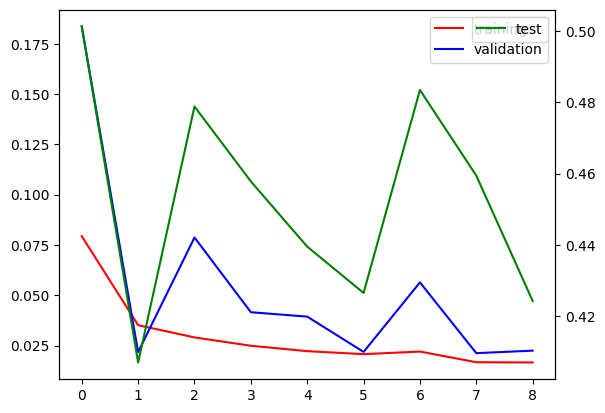

In [10]:
# plt.plot(trainloss)
# plt.plot(valloss)
# plt.plot(testscores)

ax1 = plt.subplot()
ax1.plot(trainloss[0:9], 'red')
ax1.plot(valloss[0:9], 'blue')
ax2 = ax1.twinx()
ax2.plot(testscores[0:9], 'green')
ax1.legend(["training", "validation"])
ax2.legend(["test"])
# print(trainloss[0:5], valloss[0:5], testscores[0:5])

In [16]:
targets= torch.zeros(1, 1, 188, 227, 288)
targets = torch.cat([targets, 1-targets], dim=1)
print(targets.shape)

torch.Size([1, 2, 188, 227, 288])


In [8]:
torch.cuda.empty_cache()

In [ ]:
np.save("ImageSizes.npy", imgshapes)

VISUALIZATION

In [40]:
## GET STATISTICS ON WHERE THE TUMORS LIE WITHIN THE SEGMENTATION MASKS

torch.manual_seed(43) # need this when we retrieve
stats = torch.zeros(len(train_dataloader)*train_batch_size, 9) # datapts x 6(cl,cw,ch,ml,mw,mh)
for i, (inputs, targets, labels) in enumerate(train_dataloader):
    for j in range(targets.size()[0]):
        tg = targets[j]
        # print(tg.size())

        # Get indexes of the voxels with 1 (tumor label)
        tumoridx = torch.nonzero(tg)[:, -3:].float() # result will be N(nonz px)x3(l,w,h)
        # print(tumoridx.size())

        # Get the centroid of the tumor and upper and lower bounds in each dimension
        tcenter = torch.mean(tumoridx, dim=0) # result is 1x3(l,w,h)
        tmins = torch.min(tumoridx, dim=0)[0]
        tmaxes = torch.max(tumoridx, dim=0)[0]

        stats[i*train_batch_size+j] = torch.cat((tmins, tcenter, tmaxes))

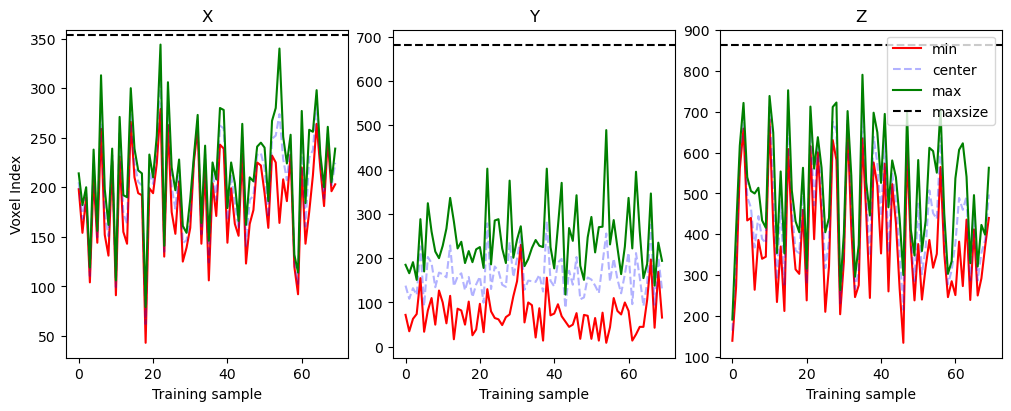

In [53]:
## PLOT TUMOR LOCATION STATS 

fig, axs = plt.subplots(1, 3, layout="constrained", figsize=(10, 4))
titles = ["X", "Y", "Z"]
maxsizes = [354, 682, 865]

axs[0].set_ylabel("Voxel Index")
for k in range(3):
    axs[k].plot(stats[:, k], color='red', linestyle='-', label="min")
    axs[k].plot(stats[:, k+3], color='blue', linestyle='--', alpha=0.3, label='center')
    axs[k].plot(stats[:, k+6], color='green', linestyle='-', label='max')
    axs[k].set_title(titles[k])
    axs[k].set_xlabel("Training sample")
    axs[k].axhline(y=maxsizes[k], color='black', linestyle='--', label='maxsize')
plt.legend()

Analyzing images for patient 069
Image size: (108, 85, 44)
1.0 1.0
Analyzing images for patient 070
Image size: (108, 85, 44)
1.0 1.0


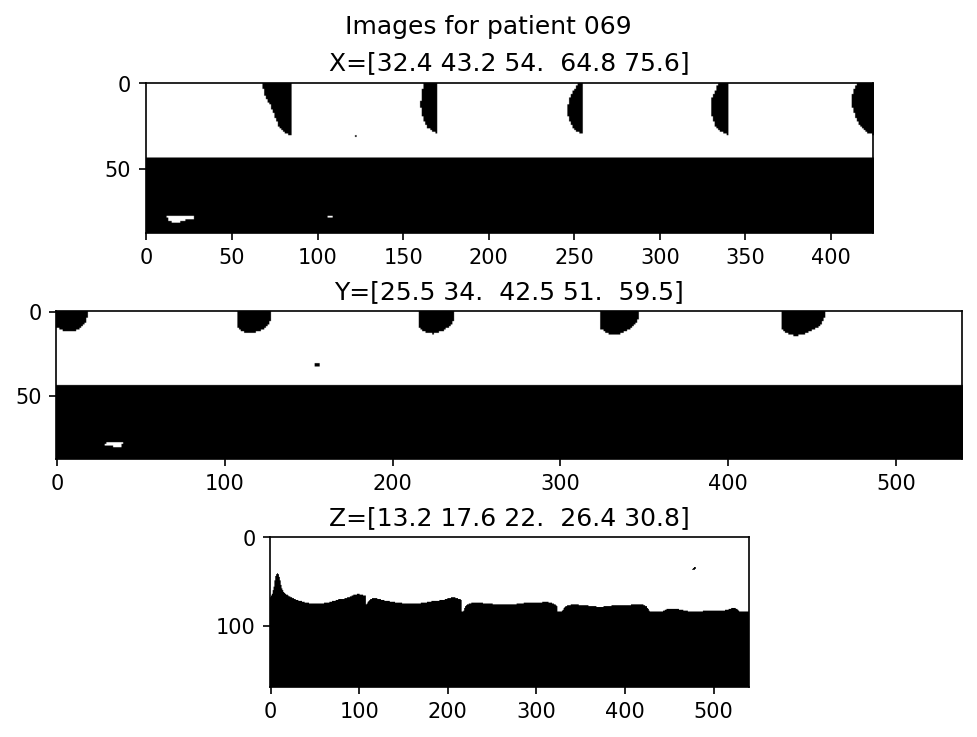

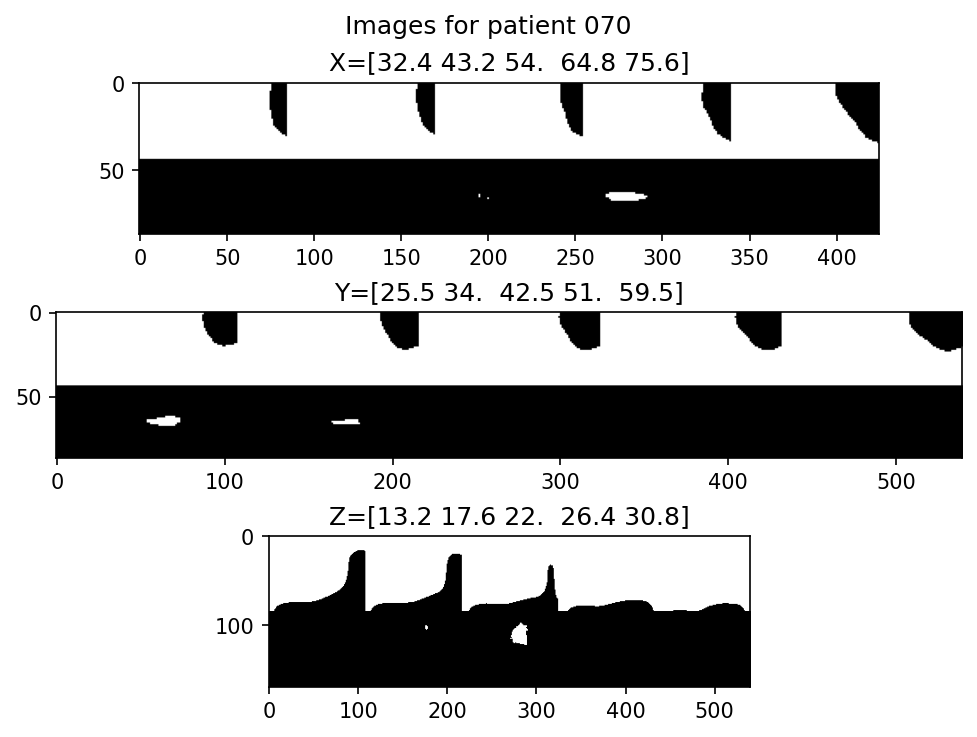

In [22]:
## PLOT SELECTED TRAINING SAMPLES ALONG WITH THEIR SEGMENTATION MASK

dir = os.path.join("Train-20230419T152017Z-001", "Train")
data_dir = os.path.join(dir, "DATA")
mask_dir = os.path.join(dir, "MASK")
label_dir = dir

slices = np.array([i/10 for i in range(3, 8)]) # slices to plot for validation (given as percentage through the height)
showresults = ["069", "070"] # choose the directories to plot the results for
for f in os.listdir(data_dir):
    if f[-8:-5] in showresults:
        # Show current directory
        print(f"Analyzing images for patient {f[-8:-5]}")
        maskname = os.path.join(mask_dir, f"MASK{f[-9:]}")
#         img = sitk.ReadImage(os.path.join(data_dir, f))
        mask = sitk.ReadImage(maskname)# * 255
        idx = int(f[-8:-5])
        img = outputs[idx-69]
        img = torch.argmin(img, dim=0)
        img = img.float().cpu()
#         img = torch.tensor(sitk.GetArrayFromImage(img))
        mask = torch.tensor(sitk.GetArrayFromImage(mask))
        pool = nn.MaxPool3d(8)
#         img = pool(img[None, None, :].float())
        mask = pool(mask[None, None, :].float())
#         img = img[0, 0]
#         mask = mask[0, 0]
        img_idx = torch.nonzeros(img)
        
        img = sitk.GetImageFromArray(img.numpy())
        mask = sitk.GetImageFromArray(mask[0, 0].numpy())
        # scale = 3
        # sz = img.GetSize()
        # temp = sitk.Image(int(sz[0]/scale), int(sz[1]/scale), int(sz[2]/scale), sitk.sitkUInt8)
        # img = sitk.Resample(img, temp, transform=sitk.ScaleTransform(3, (1, 1, 1)))
        # mask = sitk.Resample(mask, temp, transform=sitk.ScaleTransform(3, (1, 1, 1)))
        # Confirm sizes are correct
        sz = img.GetSize()
        print(f"Image size: {sz}")

        # Generate tiles of multiple top-down slices to plot
        Xslices = [img[int(s*sz[0]), :, :] for s in slices] + [mask[int(s*sz[0]), :, :] for s in slices]
        Yslices = [img[:, int(s*sz[1]), :] for s in slices] + [mask[:, int(s*sz[1]), :] for s in slices]
        Zslices = [img[:, :, int(s*sz[2])] for s in slices] + [mask[:, :, int(s*sz[2])] for s in slices]
        print(np.max(sitk.GetArrayFromImage(img)), np.max(sitk.GetArrayFromImage(mask)))
        # print(type(mask), type(img))
        
        # Convert tiles to arrays for plotting
        Xarr = sitk.GetArrayFromImage(sitk.Tile(Xslices, [len(slices), 2]))
        Yarr = sitk.GetArrayFromImage(sitk.Tile(Yslices, [len(slices), 2]))
        Zarr = sitk.GetArrayFromImage(sitk.Tile(Zslices, [len(slices), 2]))
        # print(Xarr.shape, Yarr.shape, Zarr.shape)

        # Plot tiles
        fig, axs = plt.subplots(3, 1, constrained_layout=True)
        # plt.figure()
        axs[0].imshow(Xarr, cmap='gray')
        axs[0].set_title(f"X={sz[0]*slices}")
        axs[1].imshow(Yarr, cmap='gray')
        axs[1].set_title(f"Y={sz[1]*slices}")
        axs[2].imshow(Zarr, cmap='gray')
        axs[2].set_title(f"Z={sz[2]*slices}")
        fig.suptitle(f"Images for patient {f[-8:-5]}")
        fig.set_dpi(150)